In [1]:
import os
import sys
import random

In [2]:
import scanpy
import tensorflow as tf

2025-12-13 16:38:24.395423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 16:38:25.502011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 16:38:26.907001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import squidpy
import numpy as np
import pandas as pd
from anndata import AnnData

/media/alireza/tf_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/media/alireza/tf_env/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")
/media/alireza/tf_env/lib/python3.11/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [4]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mlp
import skimage

In [5]:
import json
import seaborn

In [6]:
import copy
from ordered_set import OrderedSet

In [7]:
import DeepTalk_ST as dt

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download data

In [9]:
test_dir = './test/single-cell/'
isExsist = os.path.exists(test_dir)
if isExsist:
    pass
else:
    os.makedirs(test_dir)

In [10]:
# !wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.tar.gz

In [11]:
# !tar -xzvf visp_sn_tpm_small_0430.tar.gz -C .

## load data

In [12]:
random.seed(123)
ad_st = scanpy.read_csv(test_dir + "/st_flie.txt", delimiter='\t', first_column_names=True)
ad_st

AnnData object with n_obs × n_vars = 2399 × 268

In [13]:
ad_st_raw = copy.deepcopy(ad_st)
scanpy.pp.normalize_total(ad_st)
scanpy.pp.log1p(ad_st)

In [14]:
st_spatial = np.loadtxt(test_dir + '/st_location.txt', dtype=str, delimiter=' ' )
st_spatial = st_spatial.astype(np.float64)

In [15]:
ad_st.obs['x'] = st_spatial[:, 0]
ad_st.obs['y'] = st_spatial[:, 1]

In [16]:
ad_st.obsm["spatial"] = st_spatial
ad_st_raw.obsm['spatial'] = st_spatial

In [17]:
ad_st.obs.copy()

,x,y
0,1161.113371,6178.383054
1,1162.913371,6113.133054
2,1168.313371,6046.083054
3,1163.813371,6202.683054
4,1166.963371,6083.883054
...,...,...
2394,3144.263371,5201.433054
2395,3154.613371,5331.033054
2396,3165.413371,5190.183054
2397,3189.713371,5292.783054


In [18]:
xs = ad_st.obs.x.values
ys = ad_st.obs.y.values


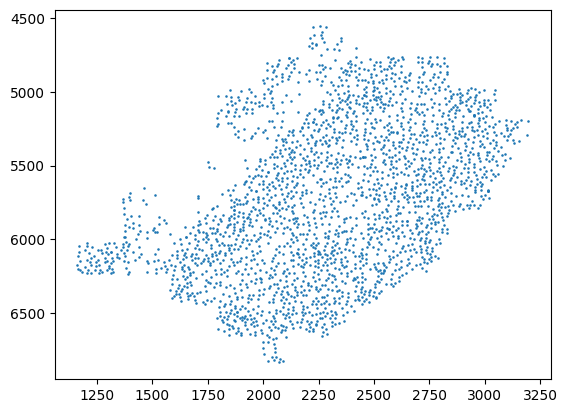

In [19]:
plt.axis('on')
plt.scatter(xs, ys, s=0.7)
plt.gca().invert_yaxis()

In [20]:
path = os.path.join(test_dir + '/visp_sn_tpm_small_0430.h5ad')
ad_sc = scanpy.read_h5ad(path)

In [26]:
ad_sc

AnnData object with n_obs × n_vars = 11759 × 24590
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

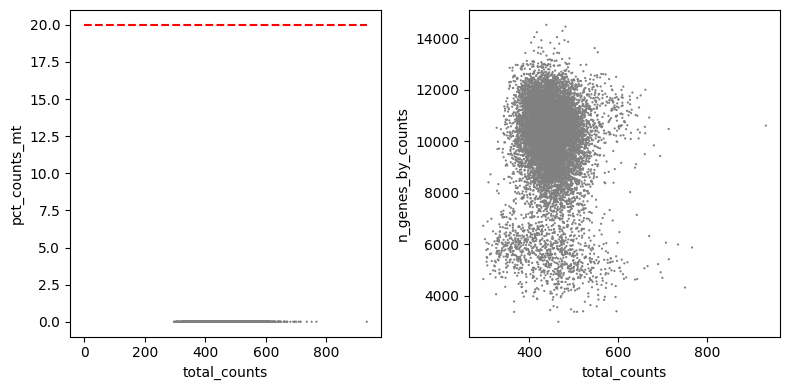

In [22]:
ad_sc.var['mt'] = ad_sc.var_names.str.startswith(r'^(mt-|MT-)')

scanpy.pp.calculate_qc_metrics(ad_sc, inplace=True, percent_top=[20], log1p =True, qc_vars=['mt']  )

fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
scanpy.pl.scatter(ad_sc, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
scanpy.pl.scatter(ad_sc, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

ad_sc = ad_sc[ad_sc.obs['pct_counts_mt'] < 20]
ad_sc = ad_sc[ad_sc.obs['n_genes_by_counts'] < 15000]
ad_sc = ad_sc[ad_sc.obs['total_counts'] < 1000]


axs[0].hlines(y = 20, xmin = 0, xmax=max(ad_sc.obs['total_counts']), color='red', ls='dashed')
fig.tight_layout()
plt.show()

In [ ]:
scanpy.pp.filter_cells(ad_sc, min_genes=200)
scanpy.pp.filter_genes(ad_sc, min_cells=3)
# ad_sc_raw0 = copy.deepcopy(ad_sc)
scanpy.pp.normalize_total(ad_sc)

# ad_sc_raw1 = copy.deepcopy(ad_sc)
scanpy.pp.log1p(ad_sc)
ad_sc_raw = copy.deepcopy(ad_sc)
scanpy.pp.filter_genes(ad_sc, min_counts=1)
scanpy.pp.highly_variable_genes(ad_sc, min_mean=0.0125, max_mean=4, min_disp=0.25)
scanpy.pp.scale(ad_sc, max_value=10)
# ad_sc_raw2 = copy.deepcopy(ad_sc)
scanpy.pp.pca(ad_sc)
scanpy.pp.neighbors(ad_sc)
scanpy.tl.umap(ad_sc)

In [27]:
ad_sc

AnnData object with n_obs × n_vars = 11759 × 24590
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
ad_sc_raw.obsm['X_umap'] = ad_sc.obsm['X_umap']

## perpare to integration

In [29]:
df_genes = pd.read_csv(test_dir + 'MERFISH_genes.csv', header=None)
markers = np.reshape(df_genes.values[:,-1], (-1, ))
markers = list(markers)

len(markers)

254

In [30]:
dt.pp_adatas(ad_sc_raw, ad_st, genes=markers)

INFO:root:253 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:257 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## integration sc/snRNA-seq and ST data

In [31]:
ad_map = dt.map_cells_to_space(
    adata_sc=ad_sc_raw,
    adata_sp=ad_st,
    learning_rate=0.0001,
    num_epochs=1,
    device='cuda:0'
)

Start training


In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        print('memory growth enabled for gpus')
    except RuntimeError as e:
        print(f'error enabling memory growth : {e}')

memory growth enabled for gpus


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

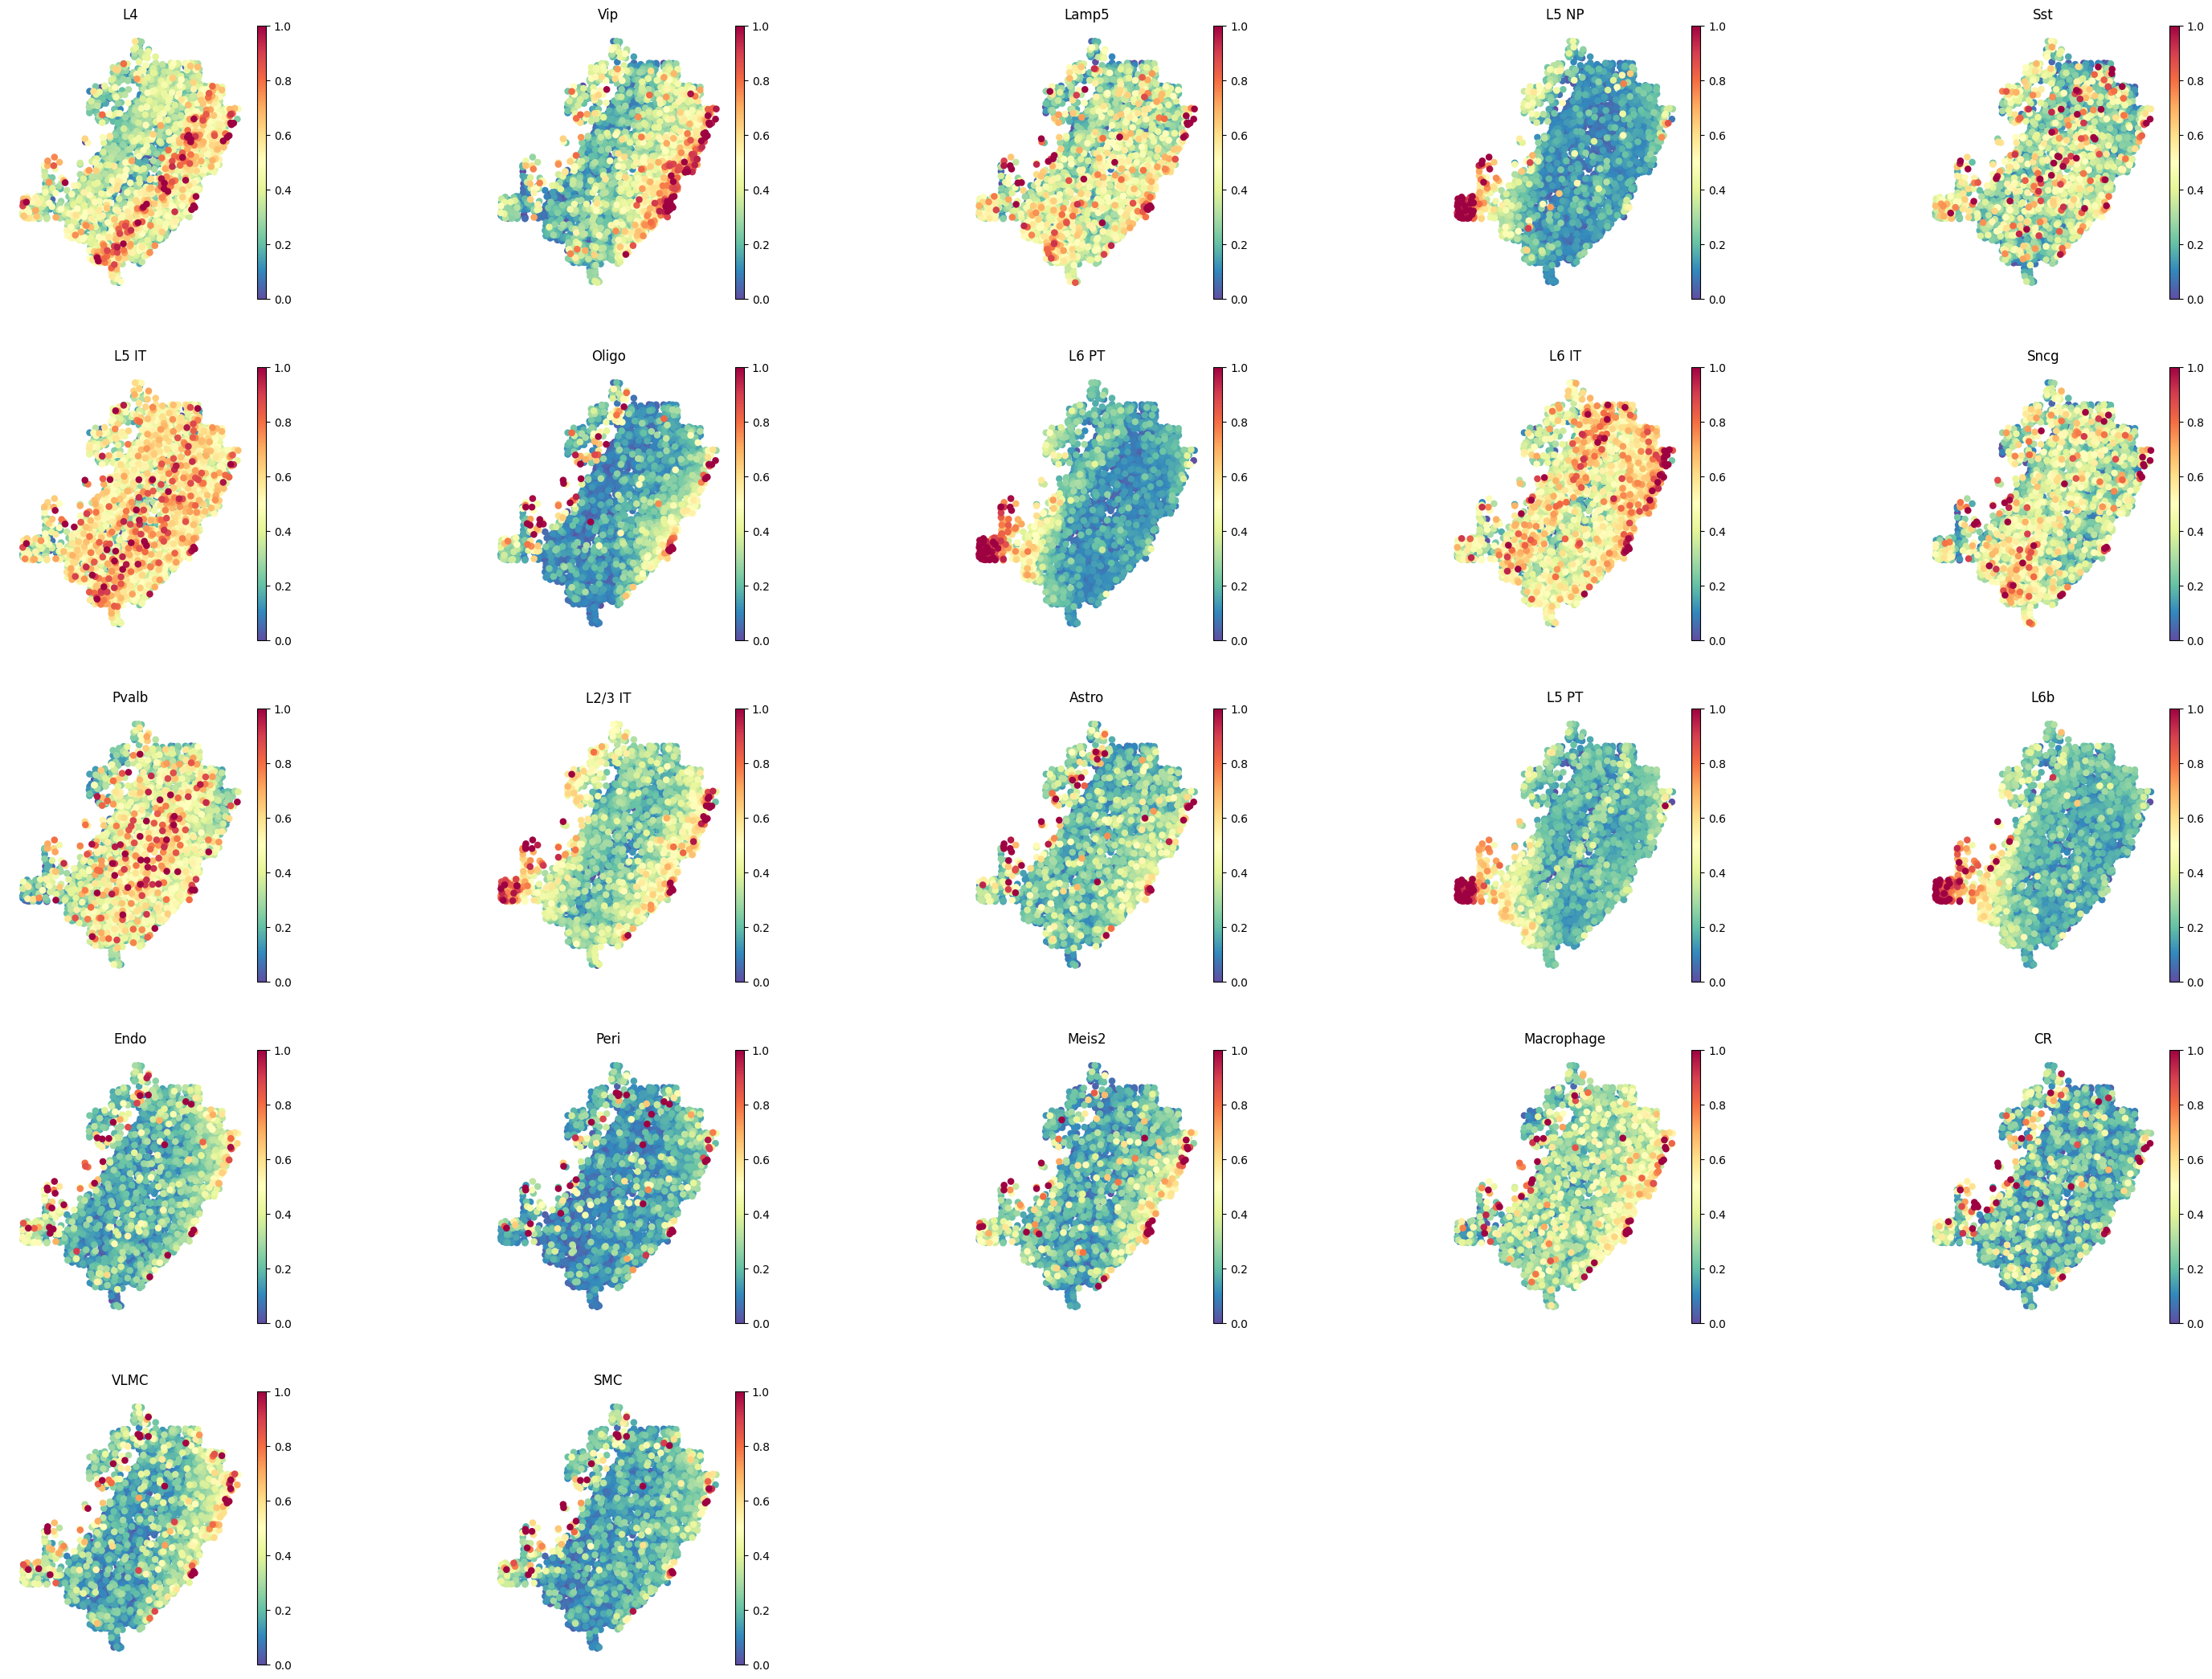

In [38]:
dt.project_cell_annotations(ad_map, ad_st, annotation="subclass")
annotation_list = list(pd.unique(ad_sc_raw.obs['subclass']))

dt.plot_cell_annotation_sc1(ad_st, annotation_list,spot_size=65, ncols=5,cmap='Spectral_r',
                            scale_factor=0.1,perc=0.01)

## prepare to inference cell-cell communication

In [ ]:
genne_all_mouse, gene_all_human = dt.gene_select(lrpairs = test_dir + 'lrpairs_new.csv', TF = test_dir + 'df_pathways.csv')

In [47]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=ad_sc_raw)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 40056
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sparsity', 'is_training'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [50]:
scanpy.pp.filter_cells(ad_ge, min_genes=200)
scanpy.pp.filter_genes(ad_ge, min_cells=3)
scanpy.pp.filter_genes_dispersion(ad_ge, flavor='cell_ranger', log=False)
ad_ge = ad_ge[:, ad_ge.X.mean(axis=0) >= 0.1]
ad_ge

View of AnnData object with n_obs × n_vars = 2399 × 2059
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sparsity', 'is_training', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [53]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [f'C{i}' for i in range(1, ad_ge.X.shape[0]+1)]
st_data = pd.DataFrame(ad_ge.X.T, index=index1, columns=c_list)
st_data = st_data[st_data.index.isin(genne_all_mouse)]

st_data

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C2390,C2391,C2392,C2393,C2394,C2395,C2396,C2397,C2398,C2399
Abhd6,0.238088,0.268476,0.252400,0.226686,0.247342,0.239755,0.239827,0.252959,0.239119,0.283107,...,0.250398,0.300050,0.224756,0.269539,0.231842,0.216805,0.274556,0.243711,0.259582,0.232365
Abi2,0.174747,0.202372,0.187659,0.166529,0.191243,0.180740,0.177507,0.190652,0.176716,0.217825,...,0.180319,0.209069,0.158719,0.187859,0.164584,0.155788,0.199767,0.172623,0.171998,0.161759
Acaa1a,0.164539,0.186541,0.180299,0.155673,0.172907,0.167870,0.165549,0.176473,0.168162,0.208045,...,0.180737,0.215100,0.158815,0.193693,0.164117,0.154314,0.203737,0.172497,0.193239,0.162814
Acat1,0.325467,0.370288,0.349278,0.309466,0.347223,0.332403,0.326583,0.351848,0.328230,0.400068,...,0.328015,0.392933,0.293896,0.349016,0.305390,0.288333,0.363377,0.320844,0.341937,0.308100
Acot13,1.309514,1.474638,1.386786,1.232794,1.377135,1.319969,1.299694,1.387768,1.313955,1.560956,...,1.329446,1.587063,1.204984,1.419706,1.241382,1.177402,1.461291,1.299290,1.415503,1.274227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhag,0.325052,0.372889,0.344842,0.308890,0.350264,0.333283,0.326975,0.348797,0.329077,0.394289,...,0.335348,0.396452,0.304785,0.356280,0.315604,0.297342,0.370536,0.326493,0.346530,0.320676
Ywhah,2.736656,3.164571,2.939782,2.635263,2.989187,2.826086,2.794730,2.994175,2.770631,3.372195,...,2.809949,3.204536,2.496099,2.893234,2.597901,2.463910,3.004164,2.679433,2.568597,2.538939
Ywhaq,0.709679,0.814937,0.772985,0.675579,0.759454,0.724896,0.715220,0.764450,0.724728,0.886867,...,0.755920,0.899520,0.677588,0.806335,0.699539,0.661984,0.842987,0.732481,0.774442,0.694662
Ywhaz,0.981839,1.126680,1.048085,0.935928,1.057205,1.004715,0.990862,1.061265,0.991316,1.191590,...,1.017533,1.189775,0.905575,1.060256,0.938558,0.886074,1.103276,0.979899,0.980907,0.930109


## generate training dataset and prediction dataset

In [61]:
pathways = test_dir + 'pathways.csv'

species = 'Mouse'
newmeta = ad_st.obs.copy()
newmeta.insert(0, 'cell', newmeta.index)
newmeta['cell'] = newmeta['cell'].astype(int)+1
newmeta['cell'] = 'C' + newmeta['cell'].astype(str)

st_coef = newmeta.iloc[: , 5:]
cellname = st_coef.columns
newmeta['celltype'] = ''
for i in range(st_coef.shape[0]):
    st_coef1 = st_coef.iloc[i, :]
    newmeta.iloc[i, newmeta.columns.get_loc('celltype')] = st_coef1.idxmax()
meta_data = newmeta[['cell', 'x', 'y', 'celltype']]

meta_data

,cell,x,y,celltype
0,C1,1161.113371,6178.383054,L6 PT
1,C2,1162.913371,6113.133054,L5 NP
2,C3,1168.313371,6046.083054,L5 NP
3,C4,1163.813371,6202.683054,L6 PT
4,C5,1166.963371,6083.883054,L5 NP
...,...,...,...,...
2394,C2395,3144.263371,5201.433054,L6 IT
2395,C2396,3154.613371,5331.033054,L4
2396,C2397,3165.413371,5190.183054,L6 IT
2397,C2398,3189.713371,5292.783054,Vip


In [62]:
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5/6 NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": "#a1ed7bff",
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

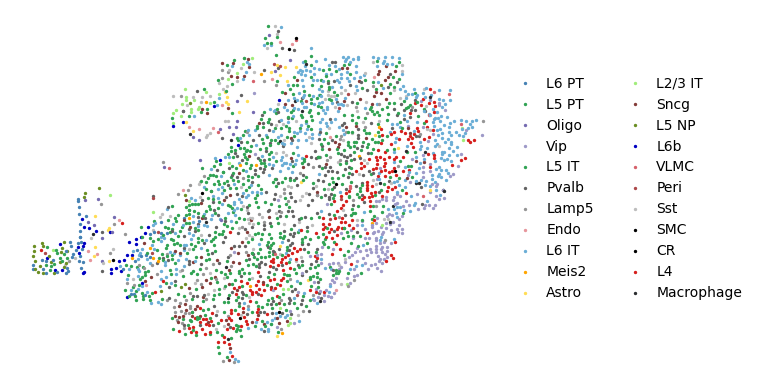

In [63]:
%matplotlib inline 

cluster = meta_data['celltype'].values
dt.plot_cell_type_ST(ad_st, mapping_colors, cluster)

## predicrion of spatial CCC at the single-cell resolution 

In [64]:
lrpairs_train = {
    'ligand' : ['Sst'],
    'receptor' : ['Sstr2'],
    'species' : ['Mouse']
}


lrpairs_train = pd.DataFrame(lrpairs_train)
lrpairs_train

,ligand,receptor,species
0,Sst,Sstr2,Mouse


In [67]:
dt.File_Train(st_data, pathways, lrpairs_train, meta_data, species, LR_train='Sst_Sstr2', outdir=test_dir)

In [80]:
dt.Train(data_name='Sst_Sstr2', data_path=test_dir + 'data', outdir=test_dir+'data/Sst_Sstr2/output',
         pretrained_embeddings=test_dir+'data/Sst_Sstr2/data_pca.emb',
         n_epochs=1,ft_n_epochs=10)


 Loading graph...


FileNotFoundError: [Errno 2] No such file or directory: './test/single-cell/data/Sst_Sstr2/train.txt'

**Predicting cell-cell communication mediated by ```Apoe-Grm5```.**

In [ ]:
lrpairs_pre = {
    'ligand' : ['Apoe'],
    'receptor' : ['Grm5'],
    'species' : ['Mouse']
}

lrpairs_pre = pd.DataFrame(lrpairs_pre)
lrpairs_pre

In [ ]:
dt.File_Pre(st_data, pathways, lrpairs_pre, meta_data, species, LR_Pre='Apoe_Grm5', outdir=test_dir)

In [ ]:
dt.data_for_pre(st_data, data_dir=test_dir + '/data/', LR_pre='Apoe_Grm5')


In [ ]:
dt.run_predict(data_name='Apoe_Grm5', data_path=test_dir+'/data/', outdir=test_dir+'/data/Apoe_Grm5/output',
               pretrained_embeddings=test_dir+'/data/Apoe_Grm5/data_pca_pre.emb',
               model_name=test_dir+'/data/Sst_Sstr2/output/finetune/results',
               best_id=8, is_trained=True, model_name=test_dir+'/Sst_Sstr2.model')

## Visualize of the spatial CCC

In [ ]:
%matplotlib inline
dt.plot_CCC_ST(ad_st, mapping_colors, cluster, st_data, ligand='Apoe', receptor='Grm5',
               CCC_label=test_dir+'/data/Apoe_Grm5/predict_ccc.txt',
               sourcetype='L2/3 IT', targettype=L4, top_score=50)

In [ ]:
%matplotlib inline

dt.plot_CCC_heatmap(cluster, st_data, ligand='Apoe', receptor='Grm5',
                    CCC_label=test_dir+'/data/Apoe_Grm5/predict_ccc.txt')